### **Quick introduction to jupyter notebooks**
* Each cell in this notebook contains either code or text.
* You can run a cell by pressing Ctrl-Enter, or run and advance to the next cell with Shift-Enter.
* Code cells will print their output, including images, below the cell. Running it again deletes the previous output, so be careful if you want to save some results.
* You don't have to rerun all cells to test changes, just rerun the cell you have made changes to. Some exceptions might apply, for example if you overwrite variables from previous cells, but in general this will work.
* If all else fails, use the "Kernel" menu and select "Restart Kernel and Clear All Output". You can also use this menu to run all cells.
* A useful debug tool is the console. You can right-click anywhere in the notebook and select "New console for notebook". This opens a python console which shares the environment with the notebook, which let's you easily print variables or test commands.

### **Setup**

In [5]:
import os
import tensorflow as tf

# If there are multiple GPUs and we only want to use one/some, set the number in the visible device list.
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"]="0"

# This sets the GPU to allocate memory only as needed
physical_devices = tf.config.experimental.list_physical_devices('GPU')
if len(physical_devices) != 0:
    tf.config.experimental.set_memory_growth(physical_devices[0], True) 

### **1. Loading the dataset**
This assignment will focus on the CIFAR10 dataset. This is a collection of small images in 10 classes such as cars, cats, birds, etc. You can find more information here: https://www.cs.toronto.edu/~kriz/cifar.html. We start by loading and examining the data.

In [6]:
import numpy as np
from tensorflow.keras.datasets import cifar10

(X_train, y_train), (X_test, y_test) = cifar10.load_data()

print("Shape of training data:")
print(X_train.shape)
print(y_train.shape)
print("Shape of test data:")
print(X_test.shape)
print(y_test.shape)

Shape of training data:
(50000, 32, 32, 3)
(50000, 1)
Shape of test data:
(10000, 32, 32, 3)
(10000, 1)


#### **<span style="color:red">Question 1:</span>**
The shape of X_train and X_test has 4 values. What do each of these represent?

#### **<span style="color:green">Answer:</span>**
The first value is the number of rows that is, the number of images, in this case, 50000 and 10000 respectively. 
Each image is represented via 3 channels. The first 32x32 entries are the red channel values, the second 32x32 entries are the green channel values and the last 32x32 entries are the blue channel values.

Each row contains of the input data contains 32 arrays, which in turn contain 32 arrays of size 3 arrays which represent the RGB channel values for each pixel.

##### **Plotting some images**
This plots a random selection of images from each class. Rerun the cell to see a different selection.

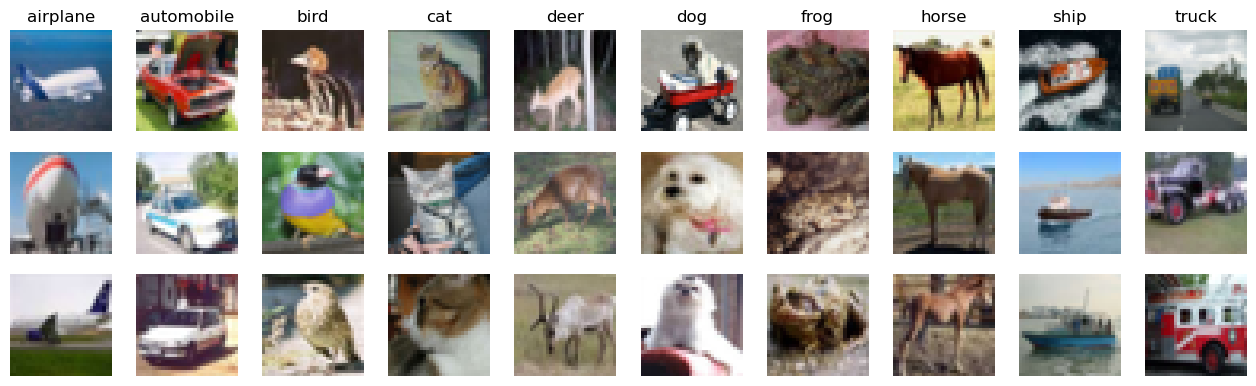

In [7]:
from Custom import PlotRandomFromEachClass

cifar_labels = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
PlotRandomFromEachClass(X_train, y_train, 3, labels=cifar_labels)

##### **Preparing the dataset**
Just like the MNIST dataset we normalize the images to [0,1] and transform the class indices to one-hot encoded vectors.

In [8]:
from tensorflow.keras.utils import to_categorical

# Transform label indices to one-hot encoded vectors
y_train_c = to_categorical(y_train, num_classes=10)
y_test_c  = to_categorical(y_test , num_classes=10)

# Normalization of pixel values (to [0-1] range)
X_train = X_train.astype('float32') / 255
X_test  = X_test.astype('float32')  / 255

In [9]:
# from tensorflow.keras.optimizers import SGD
# from tensorflow.keras.models import Model
# from tensorflow.keras.layers import Input, Dense, Flatten
# x_in = Input(shape=X_train.shape[1:])
# x = Flatten()(x_in)
# x

### **2. Fully connected classifier**
We will start by creating a fully connected classifier using the ```Dense``` layer. We give you the first layer that flattens the image features to a single vector. Add the remaining layers to the network.

Consider what the size of the output must be and what activation function you should use in the output layer.

In [10]:
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Flatten

x_in = Input(shape=X_train.shape[1:])
x = Flatten()(x_in)

# --------------------------------------------
# === Your code here =========================
# --------------------------------------------
x = Dense(35, activation='sigmoid')(x)
# x = Dense(25, activation='sigmoid')(x)
x = Dense(10, activation='softmax')(x)

# ============================================

model = Model(inputs=x_in, outputs=x)

# Now we build the model using Stochastic Gradient Descent with Nesterov momentum. We use accuracy as the metric.
sgd = SGD(learning_rate=0.01, decay=1e-6, momentum=0.9, nesterov=True)
model.compile(optimizer=sgd, loss='categorical_crossentropy', metrics=['accuracy'])
model.summary(100)

2023-02-06 18:28:56.416070: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-02-06 18:28:56.416445: I tensorflow/compiler/jit/xla_gpu_device.cc:99] Not creating XLA devices, tf_xla_enable_xla_devices not set
2023-02-06 18:28:56.417310: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 
pciBusID: 0001:00:00.0 name: Tesla K80 computeCapability: 3.7
coreClock: 0.8235GHz coreCount: 13 deviceMemorySize: 11.17GiB deviceMemoryBandwidth: 223.96GiB/s
2023-02-06 18:28:56.417343: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1
2023-02-06 18:28:56.417371: I tensorflow/stream_executor/platform/default/dso_loa

Model: "model"
____________________________________________________________________________________________________
Layer (type)                                 Output Shape                            Param #        
input_1 (InputLayer)                         [(None, 32, 32, 3)]                     0              
____________________________________________________________________________________________________
flatten (Flatten)                            (None, 3072)                            0              
____________________________________________________________________________________________________
dense (Dense)                                (None, 35)                              107555         
____________________________________________________________________________________________________
dense_1 (Dense)                              (None, 10)                              360            
Total params: 107,915
Trainable params: 107,915
Non-trainable params: 0
____

##### **Training the model**
In order to show the differences between models in the first parts of the assignment, we will restrict the training to the following command using 15 epochs, batch size 32, and 20% validation data. From section 5 and forward you can change this as you please to increase the accuracy, but for now stick with this command.

In [11]:
history = model.fit(X_train,y_train_c, epochs=15, batch_size=32, verbose=1, validation_split=0.2)

2023-02-06 18:29:33.172503: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)
2023-02-06 18:29:33.174464: I tensorflow/core/platform/profile_utils/cpu_utils.cc:112] CPU Frequency: 2596990000 Hz


Epoch 1/15


2023-02-06 18:29:36.043265: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublas.so.10


1250/1250 [==============================] - 11s 3ms/step - loss: 2.0064 - accuracy: 0.2759 - val_loss: 1.8005 - val_accuracy: 0.3607
Epoch 2/15
1250/1250 [==============================] - 3s 2ms/step - loss: 1.7469 - accuracy: 0.3833 - val_loss: 1.7361 - val_accuracy: 0.3828
Epoch 3/15
1250/1250 [==============================] - 3s 2ms/step - loss: 1.6883 - accuracy: 0.4076 - val_loss: 1.6690 - val_accuracy: 0.4131
Epoch 4/15
1250/1250 [==============================] - 3s 2ms/step - loss: 1.6309 - accuracy: 0.4232 - val_loss: 1.6605 - val_accuracy: 0.4099
Epoch 5/15
1250/1250 [==============================] - 3s 2ms/step - loss: 1.5955 - accuracy: 0.4351 - val_loss: 1.6378 - val_accuracy: 0.4193
Epoch 6/15
1250/1250 [==============================] - 3s 2ms/step - loss: 1.5773 - accuracy: 0.4382 - val_loss: 1.6129 - val_accuracy: 0.4297
Epoch 7/15
1250/1250 [==============================] - 3s 2ms/step - loss: 1.5483 - accuracy: 0.4509 - val_loss: 1.6385 - val_accuracy: 0.4104
Ep

##### **Evaluating the model**
We use ```model.evaluate``` to get the loss and metric scores on the test data. To plot the results we give you a custom function that does the work for you.

In [12]:
score = model.evaluate(X_test, y_test_c, batch_size=128, verbose=0)

for i in range(len(score)):
    print("Test " + model.metrics_names[i] + " = %.3f" % score[i])

Test loss = 1.529
Test accuracy = 0.456


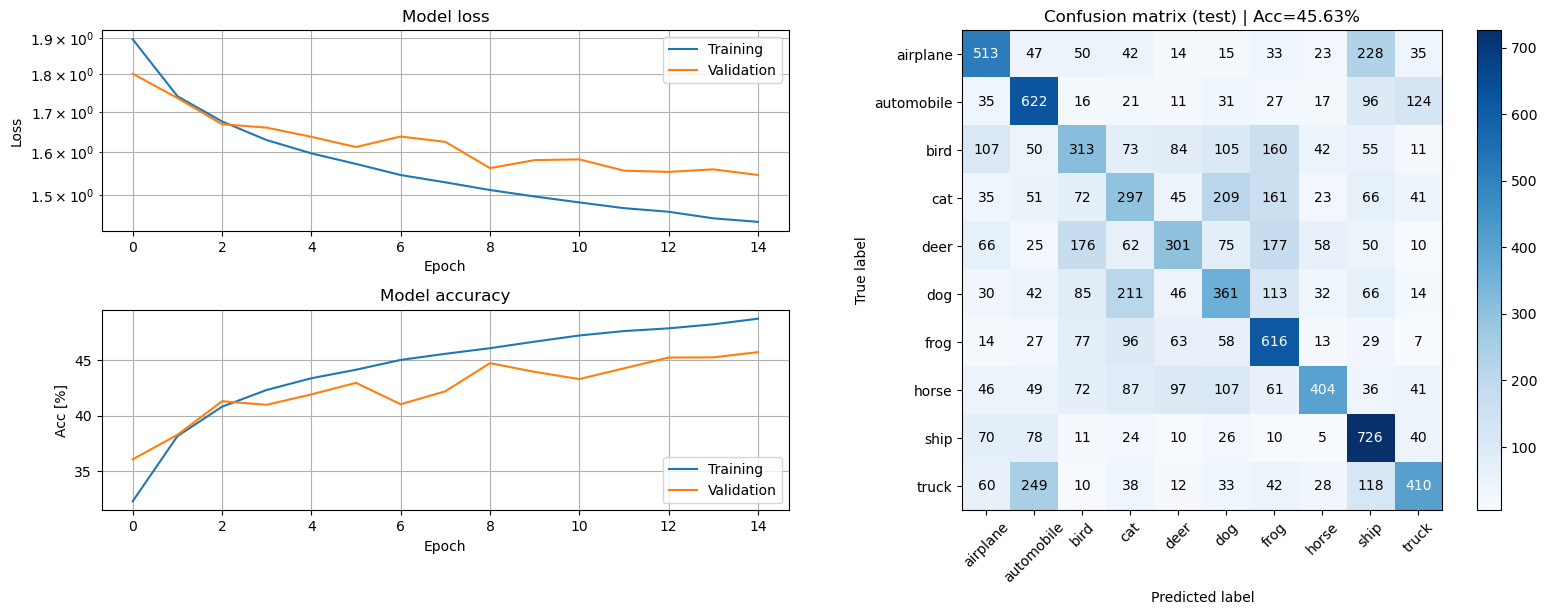

In [13]:
from Custom import PlotModelEval

# Custom function for evaluating the model and plotting training history
PlotModelEval(model, history, X_test, y_test, cifar_labels)

#### **<span style="color:red">Question 2:</span>**
Train a model that achieves above 45% accuracy on the test data. Provide a (short) motivation of your model architecture and briefly discuss the results.

#### **<span style="color:green">Answer:</span>**
We currently have a model with 2 layers where the hidden layers has 35 nodes with sigmoid activation function, and 10 output nodes since we have 10 classes to classify with a softmax activation function. This means that we now have 107,915 parameters across the network.

Initially we used 15 nodes(which kept the number of parameters lesser than the number of data samples) with a tanh activation function which gave us an accuracy of ~38%. Upon increasing the parameters to 35, we started achieving accuracies above 45%. 

We also tried increasing the number of hidden layers by capping the nodes at 15, but the expected accuracy was not being achieved.

#### **<span style="color:red">Question 3:</span>**
Compare this model to the one you used for the MNIST dataset in the first assignment, in terms of size and test accuracy. Why do you think this dataset is much harder to classify than the MNIST handwritten digits?

#### **<span style="color:green">Answer:</span>**
The MNIST dataset had 5620 dataset with only 64 features (2-D data with 8x8 pixel values for each image) and hence we managed to achieve 93% accuracy. But in this case we have 50000 data samples, where each image is represented by 32x32 pixel values across 3 channels, meaning that we have 3072 features, which makes it a very high dimensional and complicated dataset.

### **3. CNN classifier**
We will now move on to a network architecture that is more suited for this problem, the convolutional neural network. The new layers you will use are ```Conv2D``` and ```MaxPooling2D```, which you can find the documentation of here https://www.tensorflow.org/api_docs/python/tf/keras/layers/Conv2D and here https://www.tensorflow.org/api_docs/python/tf/keras/layers/MaxPool2D.

##### **Creating the CNN model**

A common way to build convolutional neural networks is to create blocks of layers of the form **[convolution - activation - pooling]**, and then stack several of these block to create the full convolution stack. This is often followed by a fully connected network to create the output classes. Use this recipe to build a CNN that acheives at least 62% accuracy on the test data.

*Side note. Although this is a common way to build CNNs, it is be no means the only or even best way. It is a good starting point, but later in part 5 you might want to explore other architectures to acheive even better performance.*

In [14]:
def convolution_nn(filters, input_layer):
#     x = Conv2D(filters, (5,5), activation='relu', input_shape = (32, 32, 3))(input_layer)
#     x = Conv2D(filters, (5,5), activation='relu', input_shape = (32, 32, 3))(x)
    x = Conv2D(filters, (5,5), activation='relu', padding='same')(input_layer)#can we remove the activation here?
    x = Conv2D(filters, (5,5), activation='relu', padding='same')(x)
    x = MaxPooling2D(pool_size=(2, 2))(x)
    return x

In [15]:
from tensorflow.keras.layers import Conv2D, MaxPooling2D

x_in = Input(shape=X_train.shape[1:])

# --------------------------------------------
# === Your code here =========================
# --------------------------------------------
block1 = convolution_nn(10, x_in)
block2 = convolution_nn(20, block1)
block3 = convolution_nn(30, block2)
# x = convolution_nn(128, x)

# x = Conv2D(32, (4,4), activation='relu', input_shape = (32, 32, 3))(x_in)
# x = Conv2D(32, (4,4), activation='relu', input_shape = (32, 32, 3))(x)
# x = MaxPooling2D(pool_size=(2, 2))(x)

y = Flatten()(block3)

y = Dense(15, activation='relu')(y)
# x = Dense(25, activation='sigmoid')(x)
y = Dense(10, activation='softmax')(y)
# ============================================

model = Model(inputs=x_in, outputs=y)

sgd = SGD(learning_rate=0.01, decay=1e-6, momentum=0.9, nesterov=True)
model.compile(loss='categorical_crossentropy', metrics=['accuracy'], optimizer=sgd)
model.summary(100)

Model: "model_1"
____________________________________________________________________________________________________
Layer (type)                                 Output Shape                            Param #        
input_2 (InputLayer)                         [(None, 32, 32, 3)]                     0              
____________________________________________________________________________________________________
conv2d (Conv2D)                              (None, 32, 32, 10)                      760            
____________________________________________________________________________________________________
conv2d_1 (Conv2D)                            (None, 32, 32, 10)                      2510           
____________________________________________________________________________________________________
max_pooling2d (MaxPooling2D)                 (None, 16, 16, 10)                      0              
__________________________________________________________________________

##### **Training the CNN**

In [16]:
history = model.fit(X_train, y_train_c, batch_size=32, epochs=15, verbose=1, validation_split=0.2)

Epoch 1/15


2023-02-06 18:30:50.899404: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudnn.so.7
2023-02-06 18:31:11.558610: W tensorflow/stream_executor/gpu/asm_compiler.cc:63] Running ptxas --version returned 256
2023-02-06 18:31:11.586349: W tensorflow/stream_executor/gpu/redzone_allocator.cc:314] Internal: ptxas exited with non-zero error code 256, output: 
Relying on driver to perform ptx compilation. 
Modify $PATH to customize ptxas location.
This message will be only logged once.


1250/1250 [==============================] - 38s 9ms/step - loss: 2.1795 - accuracy: 0.1757 - val_loss: 1.6838 - val_accuracy: 0.3919
Epoch 2/15
1250/1250 [==============================] - 10s 8ms/step - loss: 1.5730 - accuracy: 0.4219 - val_loss: 1.4416 - val_accuracy: 0.4775
Epoch 3/15
1250/1250 [==============================] - 9s 8ms/step - loss: 1.4057 - accuracy: 0.4850 - val_loss: 1.3695 - val_accuracy: 0.4972
Epoch 4/15
1250/1250 [==============================] - 10s 8ms/step - loss: 1.3136 - accuracy: 0.5292 - val_loss: 1.2548 - val_accuracy: 0.5519
Epoch 5/15
1250/1250 [==============================] - 10s 8ms/step - loss: 1.2442 - accuracy: 0.5572 - val_loss: 1.2427 - val_accuracy: 0.5556
Epoch 6/15
1250/1250 [==============================] - 10s 8ms/step - loss: 1.1701 - accuracy: 0.5810 - val_loss: 1.2166 - val_accuracy: 0.5685
Epoch 7/15
1250/1250 [==============================] - 10s 8ms/step - loss: 1.1407 - accuracy: 0.6026 - val_loss: 1.2473 - val_accuracy: 0.56

##### **Evaluating the CNN**

In [17]:
score = model.evaluate(X_test, y_test_c, batch_size=128, verbose=0)

for i in range(len(score)):
    print("Test " + model.metrics_names[i] + " = %.3f" % score[i])

Test loss = 1.143
Test accuracy = 0.612


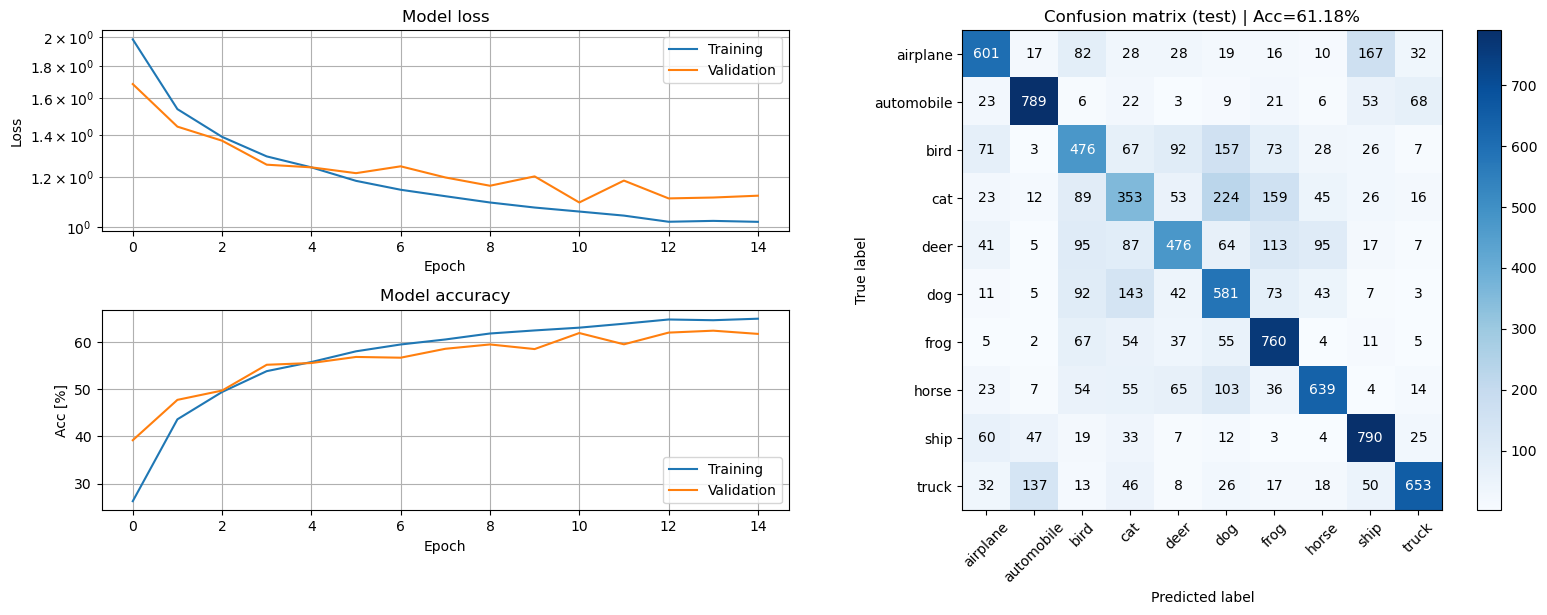

In [18]:
PlotModelEval(model, history, X_test, y_test, cifar_labels)

#### **<span style="color:red">Question 4:</span>**
Train a model that achieves at least 62% test accuracy. Provide a (short) motivation of your model architecture and briefly discuss the results.

#### **<span style="color:green">Answer:</span>**
The model architecture is as follows:

- Convolutional Part of the Network: It has the following structure convolutional-activation-pooling layers. There is a convolutional layer defined by Conv2D, an activation layer, also defined by Conv2D and a max pooling layer defined by MaxPooling2D. We then create 3 blocks of this stack by passing in the number of filters and an input tensor.

- Fully connected Part of the Network: The result above is then flattened and passed through a fully connected network(as defined in the previous sections) to obtain results of the image classification.

- Results: We now are able to obtain an accuracy of ~65%, it is noteworthy to mention that while the validation error\loss stabilizes after a certain number of epochs, the training error\loss keeps reducing through all the epochs, this effect may be because the network is overfitting on the training data given that we still have more parameters than the number of data samples.

#### **<span style="color:red">Question 5:</span>**
Compare this model with the previous fully connected model. You should find that this one is much more efficient, i.e. achieves higher accuracy with fewer parameters. Explain in your own words how this is possible.

#### **<span style="color:green">Answer:</span>**

Comparision with respect to Architecture:

- This model now has a convolutional part which is a stack of convolution-activation-pooling layers. We go one step forward and create a block of these layers before passing them onto the fully connected network model. The following are the reasons why we achieve higher accuracy with Convolutional model:
    - Lesser Number of Parameters: The number of parameters have now reduced from ~99000 parameters to around 63000 parameters, this results in a better accuracy. This is possible due to max pooling layer which causes abstraction of the features to a smaller dimension after which we pass it into the fully connected network.
    - Shift Invariance: Since we use filters(kernel) that slide over the input image and produce feature maps, which are then processed by the next layer it enables the network to learn the features better irrespective of how its position changes in the image.
    - Locality: The CNN is able to understand the relationships between lines and edges in localized neigbourhoods which is then used to learn more complex features such as textures and shapes which enables higher accuracy rates.

### **4. Regularization**

#### **4.1 Dropout**
You have probably seen that your CNN model overfits the training data. One way to prevent this is to add ```Dropout``` layers to the model, that randomly "drops" hidden nodes each training-iteration by setting their output to zero. Thus the model cannot rely on a small set of very good hidden features, but must instead learns to use different sets of hidden features each time. Dropout layers are usually added after the pooling layers in the convolution part of the model, or after activations in the fully connected part of the model.

*Side note. In the next assignment you will work with Ensemble models, a way to use the output from several individual models to achieve higher performance than each model can achieve on its own. One way to interpret Dropout is that each random selection of nodes is a separate model that is trained only on the current iteration. The final output is then the average of outputs from all the individual models. In other words, Dropout can be seen as a way to build ensembling directly into the network, without having to train several models explicitly.*

Extend your previous model with the Dropout layer and test the new performance.

In [25]:
from tensorflow.keras.layers import Dropout

x_in = Input(shape=X_train.shape[1:])

# --------------------------------------------
# === Your code here =========================
# --------------------------------------------
block1 = convolution_nn(10, x_in)
block2 = convolution_nn(20, block1)
block3 = convolution_nn(30, block2)
# x = convolution_nn(128, x)

# x = Conv2D(32, (4,4), activation='relu', input_shape = (32, 32, 3))(x_in)
# x = Conv2D(32, (4,4), activation='relu', input_shape = (32, 32, 3))(x)
# x = MaxPooling2D(pool_size=(2, 2))(x)

y = Flatten()(block3)

y = Dense(15, activation='relu')(y)
y = Dropout(0.3)(y)
# x = Dense(25, activation='sigmoid')(x)
y = Dense(10, activation='softmax')(y)
# ============================================

model = Model(inputs=x_in, outputs=y)

# Compile model
sgd = SGD(learning_rate=0.01, decay=1e-6, momentum=0.9, nesterov=True)
model.compile(loss='categorical_crossentropy', metrics=['accuracy'], optimizer=sgd)
model.summary(100)

Model: "model_3"
____________________________________________________________________________________________________
Layer (type)                                 Output Shape                            Param #        
input_4 (InputLayer)                         [(None, 32, 32, 3)]                     0              
____________________________________________________________________________________________________
conv2d_12 (Conv2D)                           (None, 32, 32, 10)                      760            
____________________________________________________________________________________________________
conv2d_13 (Conv2D)                           (None, 32, 32, 10)                      2510           
____________________________________________________________________________________________________
max_pooling2d_6 (MaxPooling2D)               (None, 16, 16, 10)                      0              
__________________________________________________________________________

In [26]:
history = model.fit(X_train, y_train_c, batch_size=32, epochs=15, verbose=1, validation_split=0.2)

Epoch 1/15
1250/1250 [==============================] - 10s 8ms/step - loss: 2.2126 - accuracy: 0.1503 - val_loss: 1.9600 - val_accuracy: 0.2762
Epoch 2/15
1250/1250 [==============================] - 10s 8ms/step - loss: 1.8318 - accuracy: 0.3002 - val_loss: 1.6442 - val_accuracy: 0.3882
Epoch 3/15
1250/1250 [==============================] - 10s 8ms/step - loss: 1.6810 - accuracy: 0.3696 - val_loss: 1.5404 - val_accuracy: 0.4422
Epoch 4/15
1250/1250 [==============================] - 9s 8ms/step - loss: 1.5858 - accuracy: 0.4045 - val_loss: 1.4339 - val_accuracy: 0.4785
Epoch 5/15
1250/1250 [==============================] - 10s 8ms/step - loss: 1.5175 - accuracy: 0.4384 - val_loss: 1.3317 - val_accuracy: 0.5207
Epoch 6/15
1250/1250 [==============================] - 10s 8ms/step - loss: 1.4465 - accuracy: 0.4712 - val_loss: 1.3251 - val_accuracy: 0.5182
Epoch 7/15
1250/1250 [==============================] - 10s 8ms/step - loss: 1.3902 - accuracy: 0.4910 - val_loss: 1.2442 - val_acc

In [27]:
score = model.evaluate(X_test, y_test_c, batch_size=128, verbose=0)

for i in range(len(score)):
    print("Test " + model.metrics_names[i] + " = %.3f" % score[i])

Test loss = 1.209
Test accuracy = 0.585


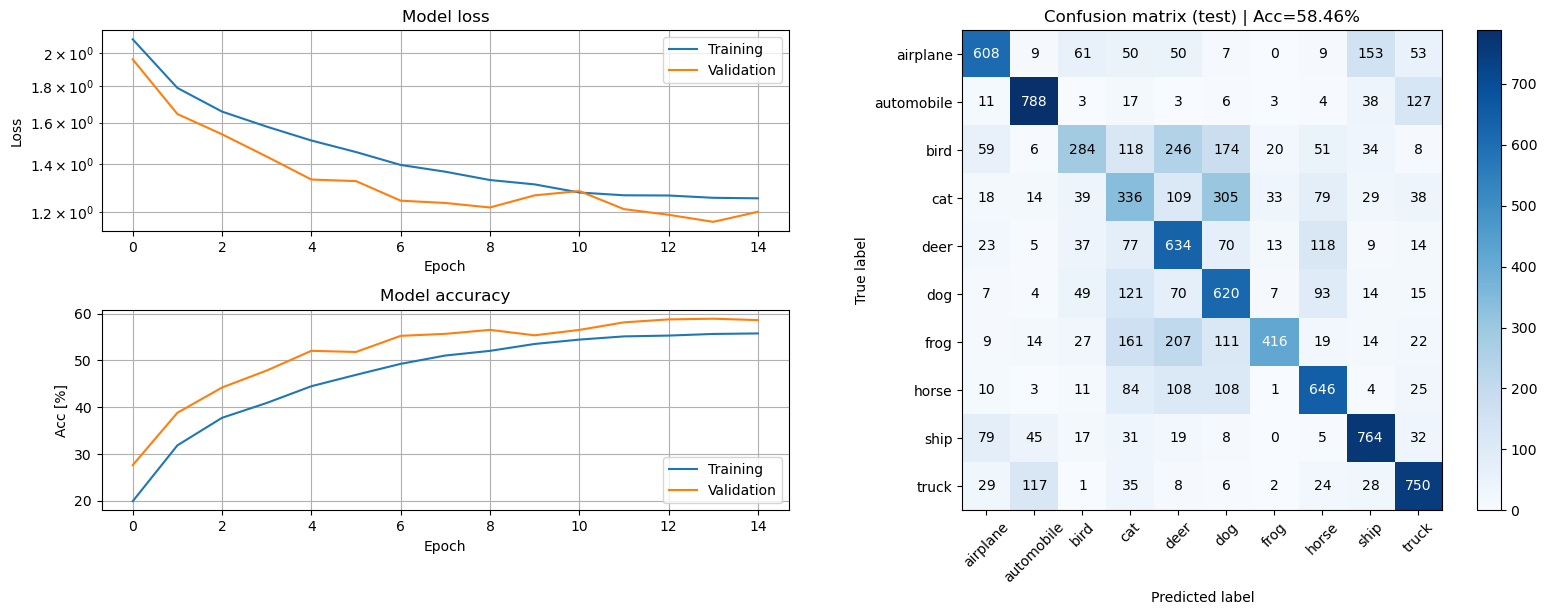

In [28]:
PlotModelEval(model, history, X_test, y_test, cifar_labels)

#### **<span style="color:red">Question 6:</span>**
Compare this model and the previous in terms of the training accuracy, validation accuracy, and test accuracy. Explain the similarities and differences (remember that the only difference between the models should be the addition of Dropout layers).

Hint: what does the dropout layer do at test time?

#### **<span style="color:green">Answer:</span>**


- Comparision with respect to Training, Validation and Test accuracies:
    - Accuracy Model1 vs Model2: We can see that the accuracies after regularization has decreased as compared to previous model because in each epoch we are turning off 35% of the nodes which means that we have lesser parameters and hence reduced accuracies which is due to the regularizing effect.

    - In the previous model, based on the trend in the accuracies, we have observed that after initial epochs, the training accuracy is always higher than validation accuracy until the end of training and the test accuracy is in turn lower than that of validation accuracy which implies that the network is overfitting on the training data. However, in this model, we observe that for the most part of the training, the general trend is that validation accuracy is higher than training accuracy and finally we get a test accuracy that is in the range of validation accuracy which implies that the regularization has reduced the overfitting effect.

- Model Similarities and Differences: 
    - Differences: The only difference in this model with respect to the previous model is that we have added a Dropout layer with a specified rate of dropout of the node outputs. We have included this layer after activation layer in the fully connected network. 
    - Similarities: The Convolutional part of the network is the same as previous model with no changes. The fully connected network is also the same with the exception of a dropout layer.

#### **4.2 Batch normalization**
The final layer we will explore is ```BatchNormalization```. As the name suggests, this layer normalizes the data in each batch to have a specific mean and standard deviation, which is learned during training. The reason for this is quite complicated (and still debated among the experts), but suffice to say that it helps the optimization converge faster which means we get higher performance in fewer epochs. The normalization is done separatly for each feature, i.e. the statistics are calculated accross the batch dimension of the input data. The equations for batch-normalizing one feature are the following, where $N$ is the batch size, $x$ the input features, and $y$ the normalized output features:

$$ \mu = \frac{1}{N} \sum_{i=0}^{N}x_i,\;\;\;\; \sigma^2 = \frac{1}{N} \sum_{i=0}^{N}(x_i - \mu)^2 $$

$$ \hat{x}_i = \frac{x_i - \mu}{\sqrt{\sigma^2 + \epsilon}} $$

$$ y_i = \gamma \hat{x}_i + \beta $$

At first glance this might look intimidating, but all it means is that we begin by scaling and shifting the data to have mean $\mu=0$ and standard deviation $\sigma=1$. After this we use the learnable parameters $\gamma$ and $\beta$ to decide the width and center of the final distribution. $\epsilon$ is a small constant value that prevents the denominator from being zero.

In addition to learning the parameters $\gamma$ and $\beta$ by gradient decent just like the weights, Batch Normalization also keeps track of the running average of minibatch statistics $\mu$ and $\sigma$. These averages are used to normalize the test data. We can tune the rate at which the running averages are updated with the *momentum* parameter of the BatchNormalization layer. A large momentum means that the statistics converge more slowly and therefore requires more updates before it represents the data. A low momentum, on the other hand, adapts to the data more quickly but might lead to unstable behaviour if the latest minibatches are not representative of the whole dataset. For this test we recommend a momentum of 0.75, but you probably want to change this when you design a larger network in Section 5.

The batch normalization layer should be added after the hidden layer linear transformation, but before the nonlinear activation. This means that we cannot specify the activation funciton in the ```Conv2D``` or ```Dense``` if we want to batch-normalize the output. We therefore need to use the ```Activation``` layer to add a separate activation to the network stack after batch normalization. For example, the convolution block will now look like **[conv - batchnorm - activation - pooling]**.

Extend your previous model with batch normalization, both in the convolution and fully connected part of the model.

In [44]:
def convolution_nn_bn(filters, input_layer):
#     x = Conv2D(filters, (5,5), activation='relu', input_shape = (32, 32, 3))(input_layer)
#     x = Conv2D(filters, (5,5), activation='relu', input_shape = (32, 32, 3))(x)
    x = Conv2D(filters, (5,5), padding='same')(input_layer)#can we remove the activation here?
    x = BatchNormalization(momentum = 0.75)(x)
    x = Activation(activation='relu')(x)
    x = MaxPooling2D(pool_size=(2, 2))(x)
    return x

In [ ]:
from tensorflow.keras.utils import plot_model

In [40]:
from tensorflow.keras.layers import BatchNormalization, Activation

x_in = Input(shape=X_train.shape[1:])

# --------------------------------------------
# === Your code here =========================
# --------------------------------------------
block1 = convolution_nn_bn(12, x_in)
block2 = convolution_nn_bn(24, block1)
block3 = convolution_nn_bn(36, block2)

y = Flatten()(block3)

y = Dense(30)(y)
y = BatchNormalization(momentum = 0.75)(y)
y = Activation(activation='relu')(y)
y = Dropout(0.3)(y)

# x = Dense(25, activation='sigmoid')(x)
y = Dense(10, activation='softmax')(y)

# ============================================

model = Model(inputs=x_in, outputs=y)

sgd = SGD(learning_rate=0.01, decay=1e-6, momentum=0.9, nesterov=True)
model.compile(loss='categorical_crossentropy', metrics=['accuracy'], optimizer=sgd)
model.summary(100)

Model: "model_10"
____________________________________________________________________________________________________
Layer (type)                                 Output Shape                            Param #        
input_11 (InputLayer)                        [(None, 32, 32, 3)]                     0              
____________________________________________________________________________________________________
conv2d_36 (Conv2D)                           (None, 32, 32, 12)                      912            
____________________________________________________________________________________________________
batch_normalization_24 (BatchNormalization)  (None, 32, 32, 12)                      48             
____________________________________________________________________________________________________
activation_24 (Activation)                   (None, 32, 32, 12)                      0              
_________________________________________________________________________

In [47]:
history = model.fit(X_train, y_train_c, batch_size=32, epochs=15, verbose=1, validation_split=0.2)

Epoch 1/15
1250/1250 [==============================] - 10s 8ms/step - loss: 1.7584 - accuracy: 0.3631 - val_loss: 1.2617 - val_accuracy: 0.5434
Epoch 2/15
1250/1250 [==============================] - 8s 7ms/step - loss: 1.3188 - accuracy: 0.5280 - val_loss: 1.1003 - val_accuracy: 0.6129
Epoch 3/15
1250/1250 [==============================] - 8s 7ms/step - loss: 1.1665 - accuracy: 0.5824 - val_loss: 1.0157 - val_accuracy: 0.6411
Epoch 4/15
1250/1250 [==============================] - 8s 7ms/step - loss: 1.0723 - accuracy: 0.6212 - val_loss: 0.9939 - val_accuracy: 0.6450
Epoch 5/15
1250/1250 [==============================] - 8s 6ms/step - loss: 1.0109 - accuracy: 0.6479 - val_loss: 0.8820 - val_accuracy: 0.6919
Epoch 6/15
1250/1250 [==============================] - 8s 6ms/step - loss: 0.9621 - accuracy: 0.6639 - val_loss: 0.8917 - val_accuracy: 0.6860
Epoch 7/15
1250/1250 [==============================] - 8s 6ms/step - loss: 0.9032 - accuracy: 0.6843 - val_loss: 0.8439 - val_accuracy

In [48]:
score = model.evaluate(X_test, y_test_c, batch_size=128, verbose=0)

for i in range(len(score)):
    print("Test " + model.metrics_names[i] + " = %.3f" % score[i])

Test loss = 0.804
Test accuracy = 0.726


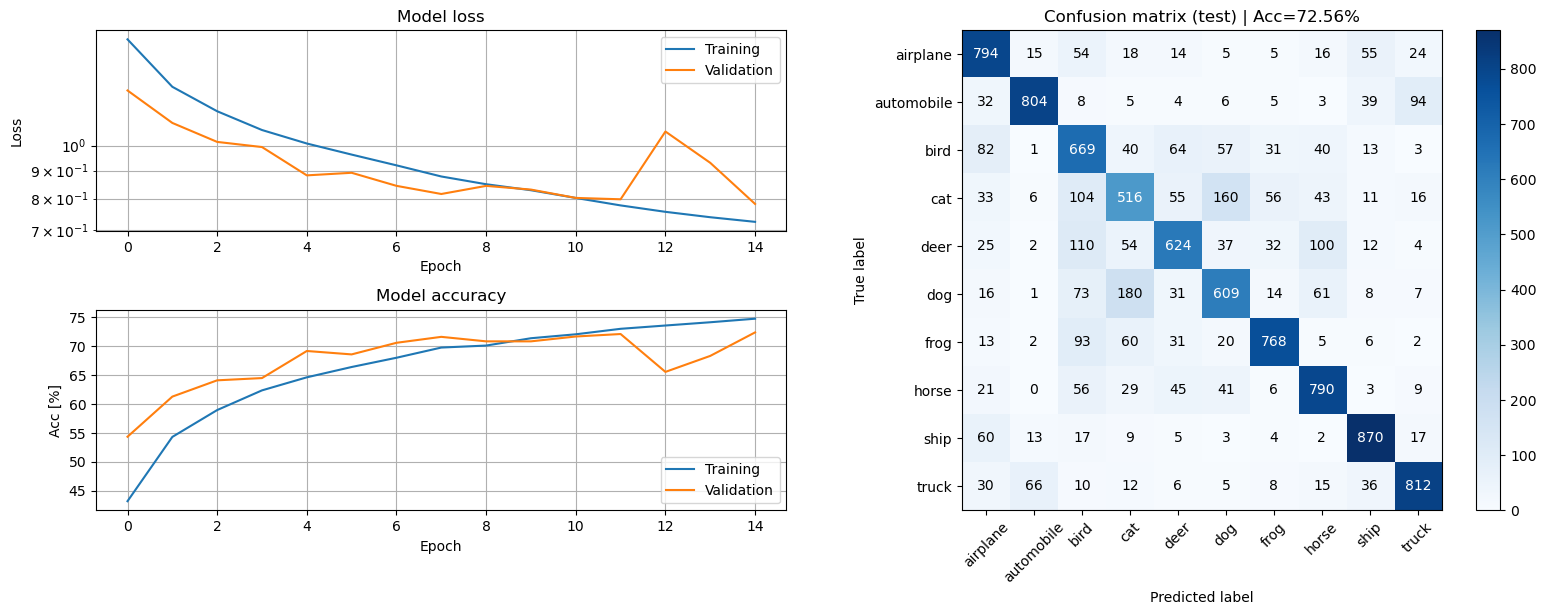

In [50]:
PlotModelEval(model, history, X_test, y_test, cifar_labels)

In [86]:
history = model.fit(X_train, y_train_c, batch_size=64, epochs=15, verbose=1, validation_split=0.2)#Batch size is very high

Epoch 1/15
625/625 [==============================] - 11s 11ms/step - loss: 0.2534 - accuracy: 0.9162 - val_loss: 0.9547 - val_accuracy: 0.7498
Epoch 2/15
625/625 [==============================] - 7s 11ms/step - loss: 0.2102 - accuracy: 0.9303 - val_loss: 1.0267 - val_accuracy: 0.7452
Epoch 3/15
625/625 [==============================] - 7s 11ms/step - loss: 0.2048 - accuracy: 0.9328 - val_loss: 1.0851 - val_accuracy: 0.7515
Epoch 4/15
625/625 [==============================] - 7s 11ms/step - loss: 0.1923 - accuracy: 0.9365 - val_loss: 1.1108 - val_accuracy: 0.7465
Epoch 5/15
625/625 [==============================] - 7s 11ms/step - loss: 0.1904 - accuracy: 0.9354 - val_loss: 1.1151 - val_accuracy: 0.7470
Epoch 6/15
625/625 [==============================] - 7s 11ms/step - loss: 0.1762 - accuracy: 0.9414 - val_loss: 1.1626 - val_accuracy: 0.7437
Epoch 7/15
625/625 [==============================] - 7s 11ms/step - loss: 0.1762 - accuracy: 0.9412 - val_loss: 1.1661 - val_accuracy: 0.745

In [90]:
score = model.evaluate(X_test, y_test_c, batch_size=128, verbose=0)

for i in range(len(score)):
    print("Test " + model.metrics_names[i] + " = %.3f" % score[i])

Test loss = 0.996
Test accuracy = 0.743


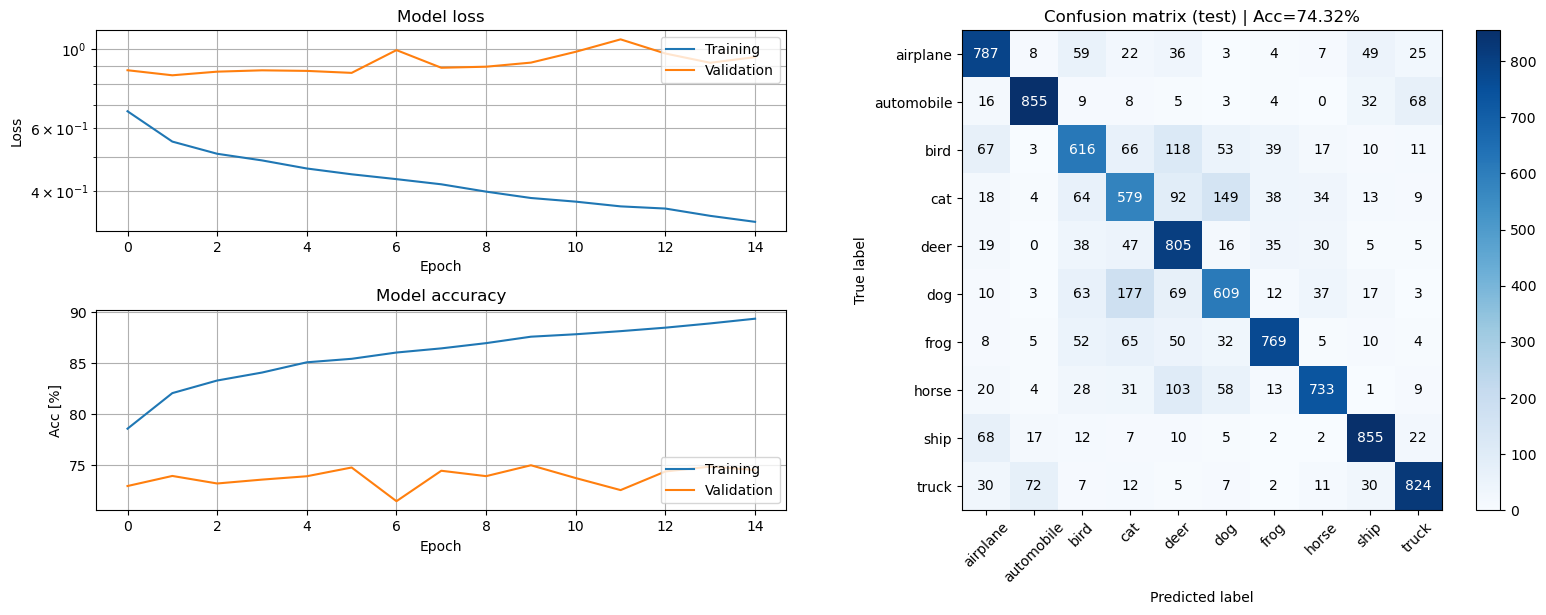

In [91]:
PlotModelEval(model, history, X_test, y_test, cifar_labels)

In [89]:
history = model.fit(X_train, y_train_c, batch_size=16, epochs=15, verbose=1, validation_split=0.2)#Batch size is very less

Epoch 1/15
2500/2500 [==============================] - 21s 8ms/step - loss: 0.6701 - accuracy: 0.7856 - val_loss: 0.8736 - val_accuracy: 0.7293
Epoch 2/15
2500/2500 [==============================] - 18s 7ms/step - loss: 0.5508 - accuracy: 0.8206 - val_loss: 0.8455 - val_accuracy: 0.7392
Epoch 3/15
2500/2500 [==============================] - 18s 7ms/step - loss: 0.5091 - accuracy: 0.8329 - val_loss: 0.8656 - val_accuracy: 0.7318
Epoch 4/15
2500/2500 [==============================] - 18s 7ms/step - loss: 0.4877 - accuracy: 0.8408 - val_loss: 0.8731 - val_accuracy: 0.7356
Epoch 5/15
2500/2500 [==============================] - 18s 7ms/step - loss: 0.4629 - accuracy: 0.8508 - val_loss: 0.8699 - val_accuracy: 0.7389
Epoch 6/15
2500/2500 [==============================] - 18s 7ms/step - loss: 0.4458 - accuracy: 0.8543 - val_loss: 0.8588 - val_accuracy: 0.7475
Epoch 7/15
2500/2500 [==============================] - 18s 7ms/step - loss: 0.4321 - accuracy: 0.8605 - val_loss: 0.9949 - val_ac

In [92]:
score = model.evaluate(X_test, y_test_c, batch_size=128, verbose=0)

for i in range(len(score)):
    print("Test " + model.metrics_names[i] + " = %.3f" % score[i])

Test loss = 0.996
Test accuracy = 0.743


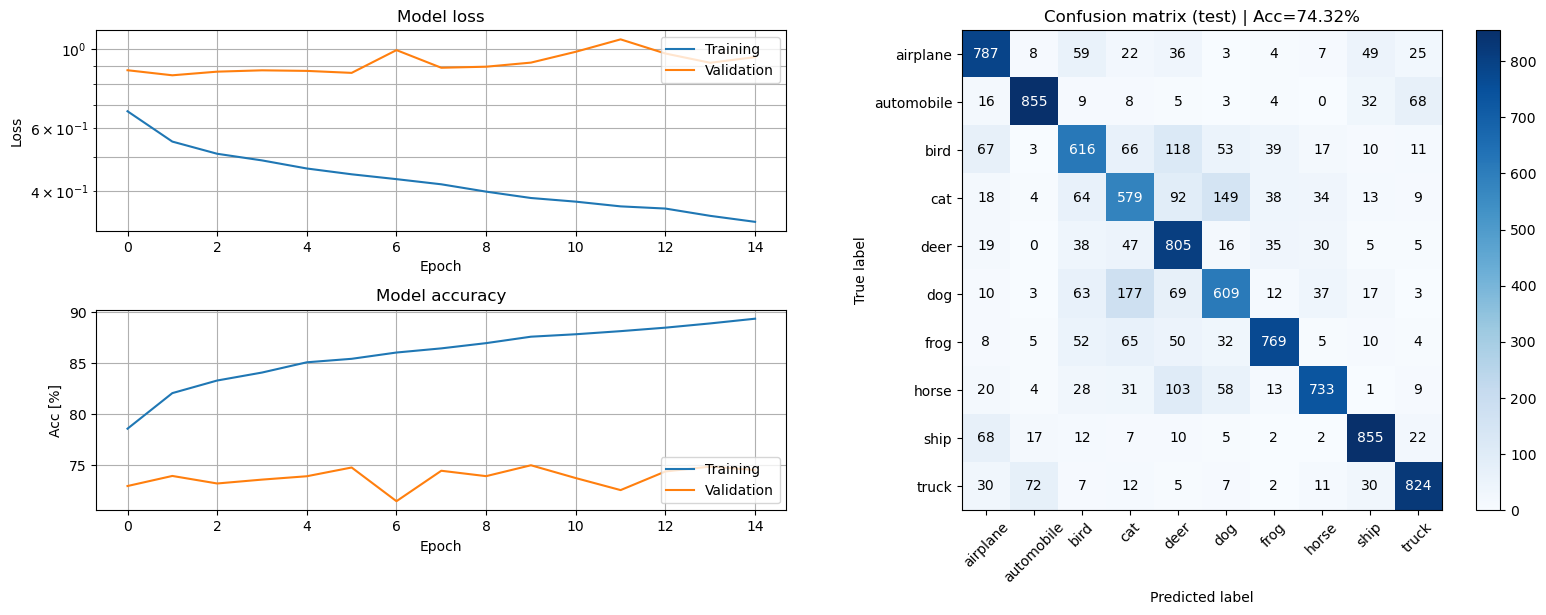

In [93]:
PlotModelEval(model, history, X_test, y_test, cifar_labels)

#### **<span style="color:red">Question 7:</span>**
When using BatchNorm one must take care to select a good minibatch size. Describe what problems might arise if:

1. The minibatch size is too small.
2. The minibatch size is too large.

You can reason about this given the description of BatchNorm above, or you can search for the information in other sources. Do not forget to provide links to the sources if you do!

#### **<span style="color:green">Answer:</span>**
- When minibatch size is too large(64)
    - The training accuracy is very high, and the validation accuracy is stagnant. Might be overfitting. Training accuracy is much higher than vaidation.

### **5. Putting it all together**
We now want you to create your own model based on what you have learned. We want you to experiment and see what works and what doesn't, so don't go crazy with the number of epochs until you think you have something that works.

To pass this assignment, we want you to acheive **75%** accuracy on the test data in no more than **25 epochs**. This is possible using the layers and techniques we have explored in this notebook, but you are free to use any other methods that we didn't cover. (You are obviously not allowed to cheat, for example by training on the test data.)

In [130]:
def convolution_nn_bn1(filters, input_layer):
    x = Conv2D(filters, (3,3), padding='same')(input_layer)#can we remove the activation here?
    x = BatchNormalization(momentum = 0.80)(x)
    x = Activation(activation='relu')(x)
    x = MaxPooling2D(pool_size=(2, 2))(x)
    return x

In [ ]:
from tensorflow.keras.layers import BatchNormalization, Activation, Add
def resnet(filters, input_layer):
    x = Conv2D(filters, (3,3), padding='same')(input_layer)#can we remove the activation here?
    x = BatchNormalization(momentum = 0.80)(x)
    x = Activation(activation='relu')(x)
    x = MaxPooling2D(pool_size=(2, 2))(x)
    
    x = Conv2D(filters, (3,3), padding='same')(x)
    x = BatchNormalization(momentum = 0.80)(x)
    
    skip = Conv2D(filters, (1,1), padding='same')(input_layer)
    x = Add()([x, skip])
    
    x = Activation(activation='relu')(x)
    x = MaxPooling2D(pool_size=(2, 2))(x)
    return x

Model: "model_34"
____________________________________________________________________________________________________
Layer (type)                                 Output Shape                            Param #        
input_36 (InputLayer)                        [(None, 32, 32, 3)]                     0              
____________________________________________________________________________________________________
conv2d_124 (Conv2D)                          (None, 32, 32, 40)                      1120           
____________________________________________________________________________________________________
batch_normalization_136 (BatchNormalization) (None, 32, 32, 40)                      160            
____________________________________________________________________________________________________
activation_136 (Activation)                  (None, 32, 32, 40)                      0              
_________________________________________________________________________

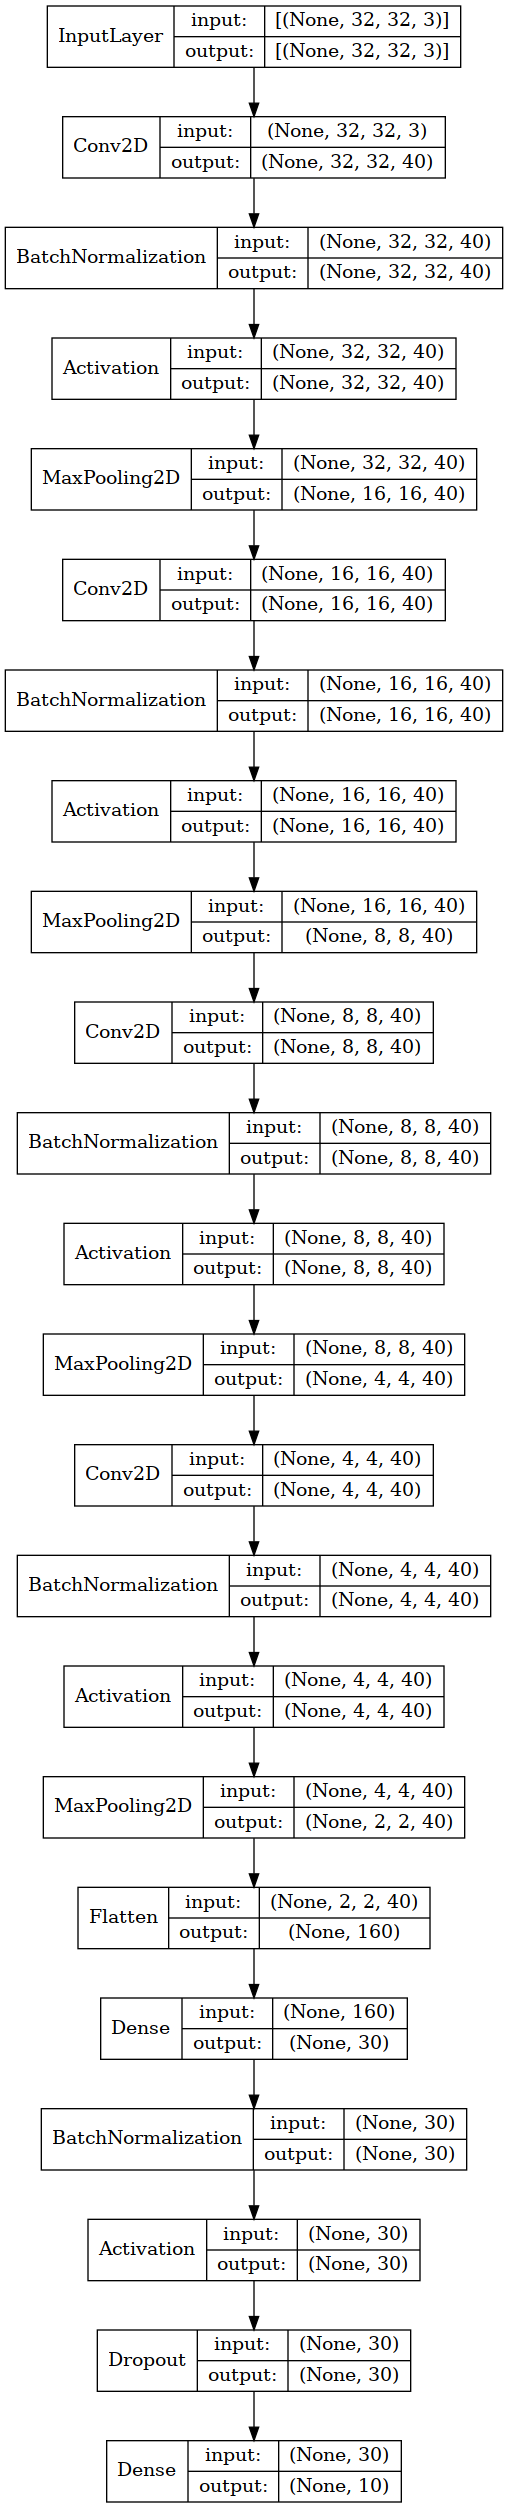

In [137]:
from tensorflow.keras.utils import plot_model

x_in = Input(shape=X_train.shape[1:])

# --------------------------------------------
# === Your code here =========================
# --------------------------------------------
block1 = convolution_nn_bn1(40, x_in)
block2 = convolution_nn_bn1(40, block1)
block3 = convolution_nn_bn1(40, block2)
block4 = convolution_nn_bn1(40, block3)

y = Flatten()(block4)

y = Dense(30)(y)
y = BatchNormalization(momentum = 0.80)(y)
y = Activation(activation='relu')(y)
y = Dropout(0.4)(y)

# x = Dense(25, activation='sigmoid')(x)
y = Dense(10, activation='softmax')(y)

# ============================================

model = Model(inputs=x_in, outputs=y)

sgd = SGD(learning_rate=0.01, decay=1e-6, momentum=0.9, nesterov=True)
model.compile(loss='categorical_crossentropy', metrics=['accuracy'], optimizer=sgd)
model.summary(100)
plot_model(model, show_shapes=True, show_layer_names=False)

In [138]:
history = model.fit(X_train, y_train_c, batch_size=16, epochs=25, verbose=1, validation_split=0.2)

Epoch 1/25
2500/2500 [==============================] - 13s 5ms/step - loss: 1.7986 - accuracy: 0.3447 - val_loss: 1.2457 - val_accuracy: 0.5458
Epoch 2/25
2500/2500 [==============================] - 12s 5ms/step - loss: 1.3441 - accuracy: 0.5157 - val_loss: 1.0269 - val_accuracy: 0.6314
Epoch 3/25
2500/2500 [==============================] - 12s 5ms/step - loss: 1.1928 - accuracy: 0.5835 - val_loss: 0.9070 - val_accuracy: 0.6810
Epoch 4/25
2500/2500 [==============================] - 12s 5ms/step - loss: 1.1118 - accuracy: 0.6141 - val_loss: 0.9006 - val_accuracy: 0.6860
Epoch 5/25
2500/2500 [==============================] - 12s 5ms/step - loss: 1.0627 - accuracy: 0.6323 - val_loss: 0.8570 - val_accuracy: 0.7002
Epoch 6/25
2500/2500 [==============================] - 12s 5ms/step - loss: 1.0051 - accuracy: 0.6547 - val_loss: 0.8017 - val_accuracy: 0.7180
Epoch 7/25
2500/2500 [==============================] - 12s 5ms/step - loss: 0.9775 - accuracy: 0.6606 - val_loss: 0.8239 - val_ac

In [136]:
score = model.evaluate(X_test, y_test_c, batch_size=128, verbose=0)

for i in range(len(score)):
    print("Test " + model.metrics_names[i] + " = %.3f" % score[i])

Test loss = 0.760
Test accuracy = 0.755


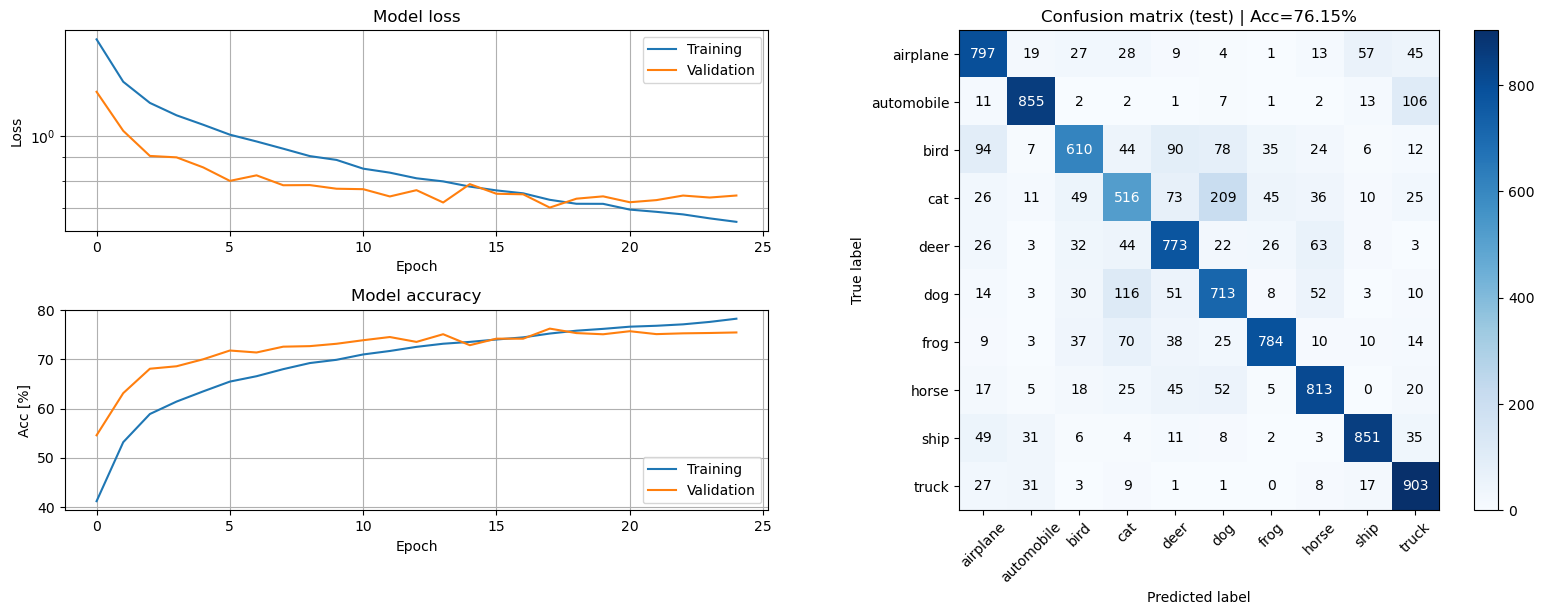

In [139]:
PlotModelEval(model, history, X_test, y_test, cifar_labels)

#### **<span style="color:red">Question 8:</span>**
Design and train a model that achieves at least 75% test accuracy in at most 25 epochs. Explain your model architecture and motivate the design choices you have made.

#### **<span style="color:green">Answer:</span>**
\[Your answer here\]

---

### **Want some extra challenge?**
For those of you that want to get creative, here are some things to look into. But note that we don't have the answers here. Any of these might improve the performance, or might not, or it might only work in combination with each other. This is up to you to figure out. This is how deep learning research often happens, trying things in a smart way to see what works best.
* Tweak or change the optimizer or training parameters.
* Tweak the filter parameters, such as numbers and sizes of filters.
* Use other activation functions.
* Add L1/L2 regularization (see https://www.tensorflow.org/api_docs/python/tf/keras/regularizers)
* Include layers that we did not cover here (see https://www.tensorflow.org/api_docs/python/tf/keras/layers). For example, our best model uses the global pooling layers.
* Take inspiration from some well-known architectures, such as ResNet or VGG16. (But don't just copy-paste those architectures. For one, what's the fun in that? Also, they take a long time to train, you will not have time.)
* Use explicit model ensembing (training multiple models that vote on or average the outputs - this will also take a lot of time.)
* Use data augmentation to create a larger training set (see https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/image/ImageDataGenerator).

In [ ]:

# --------------------------------------------
# === Your code here =========================
# --------------------------------------------

x_in = Input(shape=X_train.shape[1:])

x = ???

model = Model(inputs=x_in, outputs=x)

# You can also change this if you want
sgd = SGD(learning_rate=0.01, decay=1e-6, momentum=0.9, nesterov=True)
model.compile(loss='categorical_crossentropy', metrics=['accuracy'], optimizer=sgd)

# Print the summary and model image
model.summary(100)
plot_model(model, show_shapes=True, show_layer_names=False)

# ============================================


In [ ]:
history = model.fit(X_train, y_train_c, batch_size=32, epochs=5, verbose=1, validation_split=0.2)

In [ ]:
PlotModelEval(model, history, X_test, y_test, cifar_labels)